##**OIL SPILL DETECTION SYSTEM**

# Module 1 – Milestone 1: Data Collection

## Introduction
In Module 1, we focus on **collecting and organizing the satellite image dataset** for oil spill detection.  
The goal is to acquire labeled images and masks, verify their quality, and structure the dataset for training, validation, and testing.  
This ensures the dataset is ready for further exploration and model development.

## Dataset Acquisition
Acquired satellite images from available sources, including corresponding **oil spill masks** for supervised learning.


## Dataset Organization
Organized the dataset into structured directories:
- `train/images` and `train/masks`
- `val/images` and `val/masks`
- `test/images` and `test/masks`
to maintain clear separation between training, validation, and testing data.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2

dataset_dir = "/content/drive/MyDrive/Oil_Spill_Detection/dataset"

# Walk through all folders and print number of files
for root, dirs, files in os.walk(dataset_dir):
    print(root, len(files))



/content/drive/MyDrive/Oil_Spill_Detection/dataset 1
/content/drive/MyDrive/Oil_Spill_Detection/dataset/train 0
/content/drive/MyDrive/Oil_Spill_Detection/dataset/train/masks 811
/content/drive/MyDrive/Oil_Spill_Detection/dataset/train/images 811
/content/drive/MyDrive/Oil_Spill_Detection/dataset/val 0
/content/drive/MyDrive/Oil_Spill_Detection/dataset/val/masks 203
/content/drive/MyDrive/Oil_Spill_Detection/dataset/val/images 203
/content/drive/MyDrive/Oil_Spill_Detection/dataset/test 0
/content/drive/MyDrive/Oil_Spill_Detection/dataset/test/masks 254
/content/drive/MyDrive/Oil_Spill_Detection/dataset/test/images 254


In [3]:
import os

# Dataset directory in Google Drive
dataset_dir = "/content/drive/MyDrive/Oil_Spill_Detection/dataset"

# Train paths
train_img_dir = os.path.join(dataset_dir, "train", "images")
train_mask_dir = os.path.join(dataset_dir, "train", "masks")
train_img_paths = [os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)]
train_mask_paths = [os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)]

# Validation paths
val_img_dir = os.path.join(dataset_dir, "val", "images")
val_mask_dir = os.path.join(dataset_dir, "val", "masks")
val_img_paths = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)]
val_mask_paths = [os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)]

# Test paths
test_img_dir = os.path.join(dataset_dir, "test", "images")
test_mask_dir = os.path.join(dataset_dir, "test", "masks")
test_img_paths = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)]
test_mask_paths = [os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir)]

# Print counts
print("Train:", len(train_img_paths), len(train_mask_paths))
print("Val:", len(val_img_paths), len(val_mask_paths))
print("Test:", len(test_img_paths), len(test_mask_paths))


Train: 811 811
Val: 203 203
Test: 254 254


In [4]:
dimensions = [Image.open(os.path.join(train_img_dir, f)).size for f in os.listdir(train_img_dir)]
print("Unique dimensions in training set:", set(dimensions))

Unique dimensions in training set: {(1920, 1080), (768, 432), (3840, 2160), (5184, 2920), (4056, 3040), (5184, 3888)}


In [5]:
spill_areas = []
for f in os.listdir(train_mask_dir):
    mask = np.array(Image.open(os.path.join(train_mask_dir, f)).convert("L"))
    spill_areas.append(np.sum(mask > 0))

print("Average number of pixels with oil spill:", sum(spill_areas)/len(spill_areas))
print("Max spill area:", max(spill_areas))
print("Min spill area:", min(spill_areas))


Average number of pixels with oil spill: 2256369.404438964
Max spill area: 19513246
Min spill area: 311382


# 🛰️ Module 2: Data Preprocessing and Data Exploration

In this module, we prepare the satellite images and masks for model training.  
The main steps are:  

1. **Visualization** – Display sample satellite images with their masks to understand the dataset.  
2. **Resizing** – Standardize all images and masks to a fixed size (e.g., 256×256).  
3. **Normalization** – Scale pixel values to a common range for stable training.  
4. **SAR-specific filtering** – Apply speckle noise reduction to improve image quality.  
5. **Data Augmentation** – Increase dataset diversity with flipping, rotation, scaling, and brightness/contrast changes.  


This ensures the dataset is clean, uniform, and ready for deep learning.  


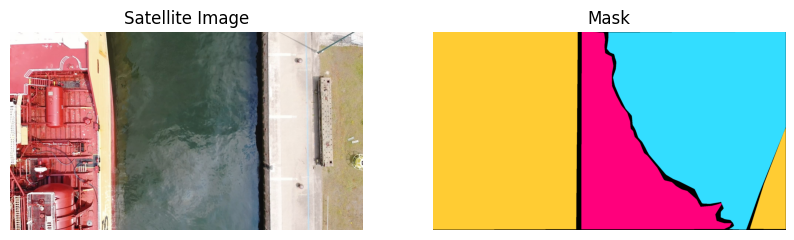

Random image path: /content/drive/MyDrive/Oil_Spill_Detection/dataset/train/images/Oil (974).jpg
Random mask path: /content/drive/MyDrive/Oil_Spill_Detection/dataset/train/masks/Oil (779).png


In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# -------------------------
# Dataset directories (Colab paths)
# -------------------------
dataset_dir = "/content/drive/MyDrive/Oil_Spill_Detection/dataset"
train_img_dir = os.path.join(dataset_dir, "train/images")
train_mask_dir = os.path.join(dataset_dir, "train/masks")

# -------------------------
# List all images and masks
# -------------------------
img_files = os.listdir(train_img_dir)
mask_files = os.listdir(train_mask_dir)

# -------------------------
# Pick a random image
# -------------------------
idx = random.randint(0, len(img_files)-1)
img_path = os.path.join(train_img_dir, img_files[idx])
mask_path = os.path.join(train_mask_dir, mask_files[idx])

# -------------------------
# Open image and mask
# -------------------------
img = Image.open(img_path)
mask = Image.open(mask_path)

# -------------------------
# Display side by side
# -------------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Satellite Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")
plt.show()

# -------------------------
# Print paths
# -------------------------
print("Random image path:", img_path)
print("Random mask path:", mask_path)


### RESIZING AND AUGMENTATION
## Key Steps:
1. **Load Image & Mask**
   - Read the input image and its corresponding mask from the dataset.
   - Images are normalized from `[0–255]` to `[0–1]`.
   - Masks are binarized so that oil spill regions = `1`, background = `0`.

2. **Resize**
   - Both images and masks are resized to a fixed size of **256 × 256** pixels.  
   - This ensures consistency for feeding into the deep learning model.

3. **Median Filtering**
   - A **median filter** is applied to the images.
   - This helps to reduce noise while preserving important edges, which is useful in satellite/ocean images.

4. **Maintain Original Copy**
   - Both original and preprocessed versions are kept.
   - This allows us to visualize how preprocessing changes the data.

5. **Visualization**
   - Random samples from the dataset are plotted in a 2×2 grid:
     - Original Image  
     - Original Mask  
     - Resized Image (after preprocessing)  
     - Resized Mask  
   - This helps verify if the preprocessing pipeline is working correctly.


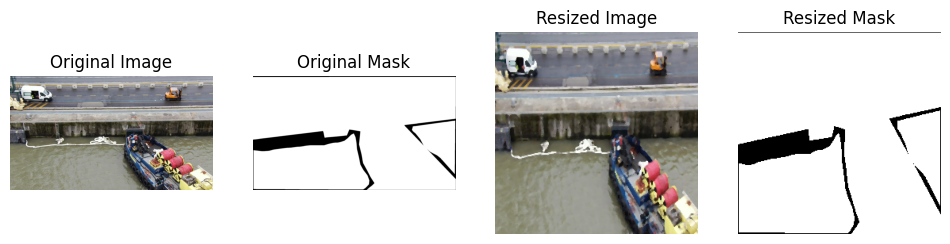

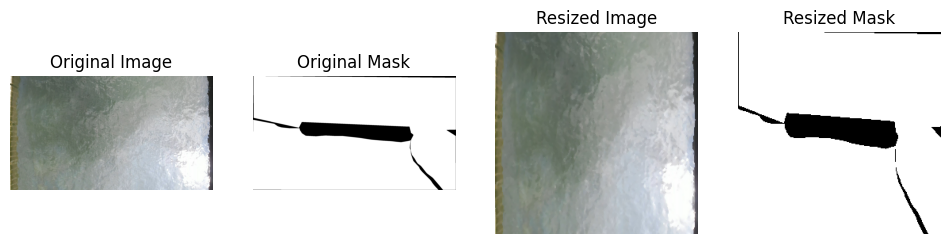

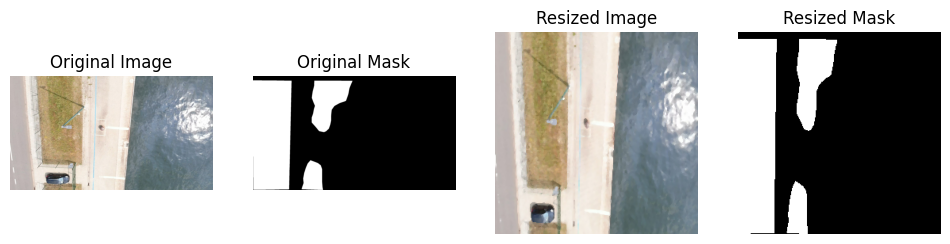

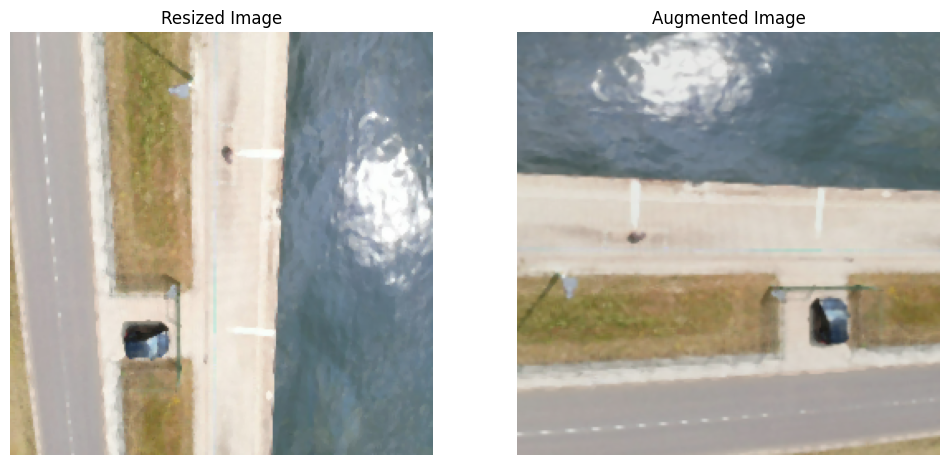

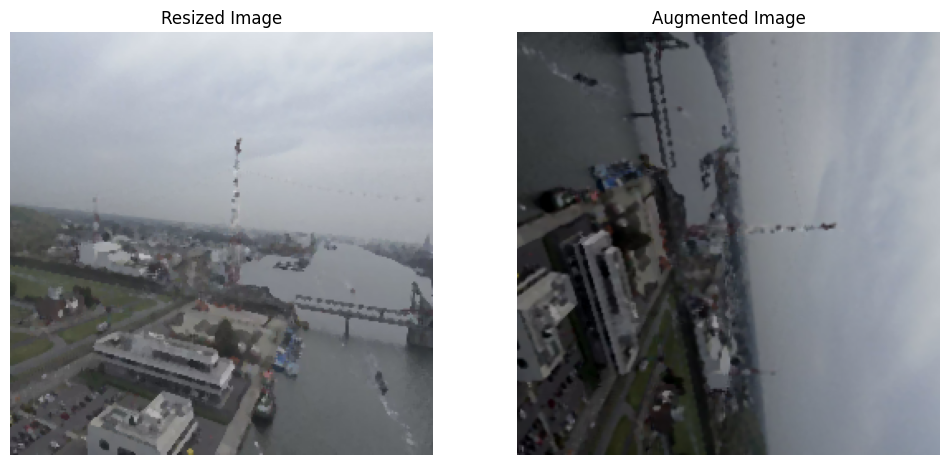

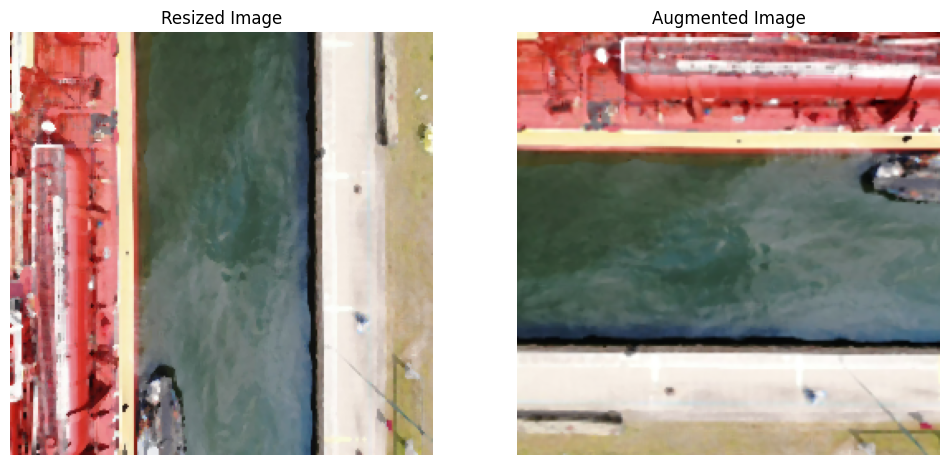

In [7]:
# ==========================
# IMPORTS
# ==========================
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np

# ==========================
# SETTINGS
# ==========================
IMG_SIZE = (256, 256)
TRAIN_IMG_DIR = "/content/drive/MyDrive/Oil_Spill_Detection/dataset/train/images"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Oil_Spill_Detection/dataset/train/masks"

# ==========================
# FUNCTIONS
# ==========================

# Median filter preprocessing
def median_filter(img_tensor):
    img = img_tensor.numpy()
    img = cv2.medianBlur((img*255).astype(np.uint8), 3)
    img = img.astype(np.float32) / 255.0
    return img

# Parse original + resize
def parse_and_resize(img_path, mask_path):
    # Original
    orig_img = tf.io.read_file(img_path)
    orig_img = tf.image.decode_jpeg(orig_img, channels=3)
    orig_img = tf.image.convert_image_dtype(orig_img, tf.float32)

    orig_mask = tf.io.read_file(mask_path)
    orig_mask = tf.image.decode_png(orig_mask, channels=1)
    orig_mask = tf.image.convert_image_dtype(orig_mask, tf.float32)
    orig_mask = tf.where(orig_mask > 0.5, 1.0, 0.0)

    # Resized
    resized_img = tf.image.resize(orig_img, IMG_SIZE)
    resized_mask = tf.image.resize(orig_mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Median filter on resized image
    resized_img = tf.py_function(median_filter, [resized_img], tf.float32)
    resized_img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    resized_mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])

    return orig_img, orig_mask, resized_img, resized_mask

# Apply augmentation on resized image/mask
def apply_augmentation(img, mask):
    aug_img = img
    aug_mask = mask

    if tf.random.uniform(()) > 0.5:
        aug_img = tf.image.flip_left_right(aug_img)
        aug_mask = tf.image.flip_left_right(aug_mask)
    if tf.random.uniform(()) > 0.5:
        aug_img = tf.image.flip_up_down(aug_img)
        aug_mask = tf.image.flip_up_down(aug_mask)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    aug_img = tf.image.rot90(aug_img, k)
    aug_mask = tf.image.rot90(aug_mask, k)

    aug_img = tf.image.random_brightness(aug_img, max_delta=0.15)
    aug_img = tf.image.random_contrast(aug_img, lower=0.85, upper=1.15)

    scale = tf.random.uniform([], 0.9, 1.1)
    new_size = (int(IMG_SIZE[0]*scale), int(IMG_SIZE[1]*scale))
    aug_img = tf.image.resize(aug_img, new_size)
    aug_mask = tf.image.resize(aug_mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    aug_img = tf.image.resize_with_crop_or_pad(aug_img, IMG_SIZE[0], IMG_SIZE[1])
    aug_mask = tf.image.resize_with_crop_or_pad(aug_mask, IMG_SIZE[0], IMG_SIZE[1])

    return aug_img, aug_mask

# ==========================
# VISUALIZATION FUNCTIONS
# ==========================

def show_resized_samples(n_samples=3):
    """Shows original and resized images/masks separately"""
    img_files = os.listdir(TRAIN_IMG_DIR)
    mask_files = os.listdir(TRAIN_MASK_DIR)

    for _ in range(n_samples):
        idx = random.randint(0, len(img_files)-1)
        img_path = os.path.join(TRAIN_IMG_DIR, img_files[idx])
        mask_path = os.path.join(TRAIN_MASK_DIR, mask_files[idx])

        orig_img, orig_mask, resized_img, resized_mask = parse_and_resize(img_path, mask_path)

        plt.figure(figsize=(12,6))
        plt.subplot(1,4,1)
        plt.imshow(orig_img.numpy())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1,4,2)
        plt.imshow(orig_mask.numpy().squeeze(), cmap="gray")
        plt.title("Original Mask")
        plt.axis("off")

        plt.subplot(1,4,3)
        plt.imshow(resized_img.numpy())
        plt.title("Resized Image")
        plt.axis("off")

        plt.subplot(1,4,4)
        plt.imshow(resized_mask.numpy().squeeze(), cmap="gray")
        plt.title("Resized Mask")
        plt.axis("off")
        plt.show()

def show_augmented_samples(n_samples=3):
    """Shows resized and augmented images/masks separately"""
    img_files = os.listdir(TRAIN_IMG_DIR)
    mask_files = os.listdir(TRAIN_MASK_DIR)

    for _ in range(n_samples):
        idx = random.randint(0, len(img_files)-1)
        img_path = os.path.join(TRAIN_IMG_DIR, img_files[idx])
        mask_path = os.path.join(TRAIN_MASK_DIR, mask_files[idx])

        _, _, resized_img, resized_mask = parse_and_resize(img_path, mask_path)
        aug_img, aug_mask = apply_augmentation(resized_img, resized_mask)

        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.imshow(resized_img.numpy())
        plt.title("Resized Image")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(aug_img.numpy())
        plt.title("Augmented Image")
        plt.axis("off")
        plt.show()

# ==========================
# RUN VISUALIZATION
# ==========================
show_resized_samples(n_samples=3)     # Only original + resized
show_augmented_samples(n_samples=3)   # Only resized + augmented




# Milestone 3: Week 3-4

## Module 3: Model Development (Segmentation and Classification)
- Design and implement deep learning models like U-Net or CNN-based architectures.
- Customize input layers for single-channel SAR or multi-channel satellite data.
- Build segmentation pipeline to predict oil spill regions from raw images.

## Module 4: Training and Evaluation
- Train the model with real-time data augmentation and validation.
- Use loss functions such as Dice Loss and Binary Cross-Entropy.
- Evaluate performance using metrics: Accuracy, IoU, Dice Coefficient, Precision, and Recall.
- Fine-tune hyperparameters based on validation results.


# 📌 Imports & Settings

### 🔹 Purpose  
Initialize the project by importing all necessary libraries and defining the core training parameters.  

### ⚙️ Includes  
- Imports: TensorFlow, Keras, OpenCV, NumPy, Matplotlib, Scikit-learn  
- Hyperparameters:  
  - Image size: **320 × 320**  
  - Batch size: **8**  
  - Epochs: **25**  
  - Learning rate: **2e-4**  
- Dataset directories for training images and masks  

✅ Confirmation message: `"Imports and settings loaded!"`


In [8]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Settings
IMG_SIZE = (320, 320)
IMG_HEIGHT = IMG_SIZE[0]
IMG_WIDTH = IMG_SIZE[1]
INPUT_CHANNELS = 3
BASE_FILTERS = 32
BATCH_SIZE = 8
BUFFER_SIZE = 512
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 25
LEARNING_RATE = 2e-4

dataset_dir = "/content/drive/MyDrive/Oil_Spill_Detection/dataset"
train_img_dir = os.path.join(dataset_dir, "train", "images")
train_mask_dir = os.path.join(dataset_dir, "train", "masks")

print("✅ Imports and settings loaded!")

✅ Imports and settings loaded!


In [9]:
def enhanced_preprocessing(img):
    img = img.numpy()
    img_uint8 = (img * 255).astype(np.uint8)

    img_blur = cv2.GaussianBlur(img_uint8, (3, 3), 0)
    lab = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    lab[..., 0] = clahe.apply(lab[..., 0])
    img_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    img_enhanced = cv2.bilateralFilter(img_enhanced, 9, 75, 75)
    img_enhanced = img_enhanced.astype(np.float32) / 127.5 - 1.0
    return img_enhanced

def parse_image_mask_improved(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask > 0.3, 1.0, 0.0)

    img = tf.image.resize(img, IMG_SIZE)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    img = tf.py_function(enhanced_preprocessing, [img], tf.float32)
    img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])
    return img, mask

print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


In [10]:
def advanced_augmentation(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_contrast(img, 0.7, 1.3)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_hue(img, 0.15)

    if tf.random.uniform(()) > 0.6:
        scale = tf.random.uniform([], 0.75, 1.25)
        new_size = (int(IMG_SIZE[0]*scale), int(IMG_SIZE[1]*scale))
        img = tf.image.resize(img, new_size)
        mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE[0], IMG_SIZE[1])
        mask = tf.image.resize_with_crop_or_pad(mask, IMG_SIZE[0], IMG_SIZE[1])

    if tf.random.uniform(()) > 0.7:
        shift_x = tf.random.uniform([], -20, 20, dtype=tf.int32)
        shift_y = tf.random.uniform([], -20, 20, dtype=tf.int32)
        img = tf.roll(img, shift=[shift_y, shift_x], axis=[0, 1])
        mask = tf.roll(mask, shift=[shift_y, shift_x], axis=[0, 1])

    img = tf.clip_by_value(img, -1.0, 1.0)
    return img, mask

print("✅ Augmentation functions defined!")

✅ Augmentation functions defined!


# 🏗️ Improved U-Net Building Blocks

### 🔹 Residual Convolution Block
- Two `Conv2D + BatchNorm + ReLU` layers with **residual connection**.
- Optional `SpatialDropout2D` for regularization.
- Shortcut path ensures channel matching.
- Adds non-linear residual learning → faster convergence & better gradient flow.

### 🔹 Squeeze-and-Excite Block
- **Channel-wise attention** mechanism.
- Global average pooling → dense layers → sigmoid gating.
- Scales each channel → emphasizes important features.

### 🔹 Attention Gate
- Computes **attention coefficients** for skip connections.
- Enhances relevant encoder features before concatenation in the decoder.
- Helps focus on oil spill regions.

### 🔹 Encoder Block
- Residual convolution + squeeze-excite.
- Followed by **MaxPooling** for downsampling.
- Returns features for skip connections + pooled output.

### 🔹 Decoder Block
- **Upsampling with Conv2DTranspose**.
- Skip connection refined by attention gate.
- Residual convolution + squeeze-excite after concatenation.
- Restores spatial resolution with enhanced features.

✅ Confirmation message: `"Model building blocks defined!"`


In [11]:
def conv_block_residual(x, filters, dropout_rate=0.0):
    shortcut = x

    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if dropout_rate > 0:
        x = layers.SpatialDropout2D(dropout_rate)(x)

    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def squeeze_excite_block(x, ratio=16):
    channels = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Reshape((1, 1, channels))(se)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    return layers.Multiply()([x, se])

def attention_gate(g, x):
    filters = x.shape[-1]
    g_conv = layers.Conv2D(filters, 1, padding='same')(g)
    x_conv = layers.Conv2D(filters, 1, padding='same')(x)
    add = layers.Add()([g_conv, x_conv])
    relu = layers.ReLU()(add)
    psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(relu)
    return layers.Multiply()([x, psi])

def encoder_block_improved(x, filters, dropout_rate=0.1):
    c = conv_block_residual(x, filters, dropout_rate)
    c = squeeze_excite_block(c)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block_improved(x, skip, filters, dropout_rate=0.1):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    skip = attention_gate(x, skip)
    x = layers.Concatenate()([x, skip])
    x = conv_block_residual(x, filters, dropout_rate)
    x = squeeze_excite_block(x)
    return x

print("✅ Model building blocks defined!")

✅ Model building blocks defined!


# 🏗️ Advanced U-Net Architecture (Deep Attention + Residual + SE)

### 🔹 Input
- Shape: `(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS)`
- RGB images resized for the model.

### 🔹 Encoder
- **5 Levels** of `encoder_block_improved`.
- Each level includes:
  - Residual convolution blocks
  - Squeeze-and-Excite (SE) attention
  - Downsampling via MaxPooling
- Dropout increases with depth: 0.05 → 0.25.

### 🔹 Bottleneck
- Deepest layer with `conv_block_residual` + SE block.
- Captures highly abstracted features.

### 🔹 Decoder
- **5 Levels** of `decoder_block_improved`.
- Each level includes:
  - Transposed convolution (upsampling)
  - Skip connection with **attention gate**
  - Residual convolution + SE block
- Dropout decreases with depth: 0.25 → 0.05.

### 🔹 Output
- `Conv2D` with **1 filter** and `sigmoid` activation.
- Produces binary segmentation mask.

### 🔹 Summary
- Combines **residual learning**, **channel attention**, and **spatial attention**.
- Deep skip connections enhance focus on oil spill regions.
- Total parameters: `model.count_params()` (printed dynamically).

✅ Confirmation message: `"Model built!"`


In [12]:
def build_advanced_unet():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS))

    # Encoder
    c1, p1 = encoder_block_improved(inputs, BASE_FILTERS, 0.05)
    c2, p2 = encoder_block_improved(p1, BASE_FILTERS*2, 0.1)
    c3, p3 = encoder_block_improved(p2, BASE_FILTERS*4, 0.15)
    c4, p4 = encoder_block_improved(p3, BASE_FILTERS*8, 0.2)
    c5, p5 = encoder_block_improved(p4, BASE_FILTERS*16, 0.25)

    # Bottleneck
    b = conv_block_residual(p5, BASE_FILTERS*32, 0.3)
    b = squeeze_excite_block(b)

    # Decoder
    d5 = decoder_block_improved(b, c5, BASE_FILTERS*16, 0.25)
    d4 = decoder_block_improved(d5, c4, BASE_FILTERS*8, 0.2)
    d3 = decoder_block_improved(d4, c3, BASE_FILTERS*4, 0.15)
    d2 = decoder_block_improved(d3, c2, BASE_FILTERS*2, 0.1)
    d1 = decoder_block_improved(d2, c1, BASE_FILTERS, 0.05)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', name='output')(d1)

    return models.Model(inputs, outputs, name="DeepAttentionUNet")

# Build and display model
model = build_advanced_unet()
model.summary()
print(f"\n✅ Model built! Total parameters: {model.count_params():,}")

Model: "DeepAttentionUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 320, 320,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 320, 320,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 320, 320,  │          0 │ activation[0][0]  │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 320, 320,  │      9,248 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 320, 320,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 320, 320,  │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 320, 320,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 320, 320,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 2)   │         66 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │         96 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 320, 320,  │          0 │ activation_1[0][… │
│                     │ 32)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 160, 160,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 160, 160,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        256 │ conv2d_3[0][0]  

 Total params: 33,441,314 (127.57 MB)

 Trainable params: 33,429,282 (127.52 MB)

 Non-trainable params: 12,032 (47.00 KB)


✅ Model built! Total parameters: 33,441,314


# 🎯 Custom Loss Functions for Oil Spill Segmentation

### 1️⃣ Focal Tversky Loss
- Combines **Tversky index** with **focal scaling**.
- Balances **false positives** (`alpha`) and **false negatives** (`beta`).
- `gamma` emphasizes harder-to-segment regions.
- Useful for **imbalanced datasets**.

### 2️⃣ Dice Loss
- Measures overlap between predicted and true masks.
- Formula: `1 - (2 * intersection) / (sum of areas)`.
- Encourages **high similarity** between prediction and ground truth.

### 3️⃣ Boundary Loss
- Focuses on **contour matching**.
- Penalizes differences between predicted and true mask **edges** in both X and Y directions.
- Improves **sharpness of segmentation boundaries**.

### 4️⃣ Combined Loss (Improved)
- Weighted combination:
  - 25% Binary Crossentropy
  - 35% Focal Tversky Loss
  - 25% Dice Loss
  - 15% Boundary Loss
- Captures **global, regional, and edge-level errors**.
- Ensures robust training for **oil spill detection**.

✅ Confirmation: `"Loss functions defined!"`


In [13]:
def focal_tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7, gamma=1.5, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    fp = K.sum((1 - y_true_f) * y_pred_f)

    tversky = (tp + smooth) / (tp + alpha*fn + beta*fp + smooth)
    focal_tversky = K.pow((1 - tversky), gamma)

    return focal_tversky

def dice_loss(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def boundary_loss(y_true, y_pred):
    dy_true = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]
    dx_true = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
    dy_pred = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
    dx_pred = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]

    return K.mean(K.abs(dy_true - dy_pred)) + K.mean(K.abs(dx_true - dx_pred))

def combined_loss_improved(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    focal_tv = focal_tversky_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    boundary = boundary_loss(y_true, y_pred)

    return 0.25*bce + 0.35*focal_tv + 0.25*dice + 0.15*boundary

print("✅ Loss functions defined!")

✅ Loss functions defined!


# 📊 Improved Evaluation Metrics for Oil Spill Segmentation

### 1️⃣ Dice Coefficient
- Measures overlap between predicted and ground truth masks.
- Formula: `Dice = (2 * |Prediction ∩ GroundTruth|) / (|Prediction| + |GroundTruth|)`.
- Binarizes predictions with a **0.5 threshold**.
- Values close to 1 indicate **high overlap**.

### 2️⃣ Intersection over Union (IoU)
- Measures how much predicted mask overlaps with ground truth relative to the union.
- Formula: `IoU = |Prediction ∩ GroundTruth| / |Prediction ∪ GroundTruth|`.
- Higher IoU → better segmentation accuracy.

### 3️⃣ Precision
- Measures fraction of correctly predicted positives out of all predicted positives.
- Formula: `Precision = TP / (TP + FP)`.
- High precision → fewer false positives.

### 4️⃣ Recall
- Measures fraction of correctly predicted positives out of all actual positives.
- Formula: `Recall = TP / (TP + FN)`.
- High recall → fewer false negatives.

✅ Confirmation: `"Metrics defined!"`


In [14]:
def dice_coef_improved(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred > 0.5, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_improved(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred > 0.5, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def precision_improved(y_true, y_pred, smooth=1e-7):
    y_pred_f = K.cast(y_pred > 0.5, 'float32')
    tp = K.sum(K.cast(y_true, 'float32') * y_pred_f)
    fp = K.sum((1 - K.cast(y_true, 'float32')) * y_pred_f)
    return (tp + smooth) / (tp + fp + smooth)

def recall_improved(y_true, y_pred, smooth=1e-7):
    y_pred_f = K.cast(y_pred > 0.5, 'float32')
    tp = K.sum(K.cast(y_true, 'float32') * y_pred_f)
    fn = K.sum(K.cast(y_true, 'float32') * (1 - y_pred_f))
    return (tp + smooth) / (tp + fn + smooth)

print("✅ Metrics defined!")

✅ Metrics defined!


# 📂 Dataset Preparation & Pipeline

### 1️⃣ Train-Validation Split
- **Function:** `create_train_val_split()`
- Reads all image and mask files.
- Splits them into **training** and **validation** sets (85%-15%).
- Returns: `train_imgs, train_masks, val_imgs, val_masks`.

### 2️⃣ Dataset Creation
- **Function:** `create_dataset_improved(img_paths, mask_paths, is_training=True)`
- Converts image-mask paths into a **`tf.data.Dataset`**.
- **Training pipeline**:
  - Shuffles dataset for randomness.
  - Applies `parse_image_mask_improved` preprocessing.
  - Applies `advanced_augmentation` if `is_training=True`.
- Batches and prefetches data for efficient GPU/CPU usage.
- Returns: ready-to-use TensorFlow dataset.

✅ Confirmation: `"Dataset pipeline defined!"`


In [15]:
def create_train_val_split():
    img_files = sorted([f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.png'))])
    mask_files = sorted([f for f in os.listdir(train_mask_dir) if f.endswith(('.jpg', '.png'))])
    img_paths = [os.path.join(train_img_dir, f) for f in img_files]
    mask_paths = [os.path.join(train_mask_dir, f) for f in mask_files]
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        img_paths, mask_paths, test_size=0.15, random_state=42
    )
    return train_imgs, train_masks, val_imgs, val_masks

def create_dataset_improved(img_paths, mask_paths, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if is_training:
        dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    dataset = dataset.map(parse_image_mask_improved, num_parallel_calls=AUTOTUNE)
    if is_training:
        dataset = dataset.map(advanced_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

print("✅ Dataset pipeline defined!")

✅ Dataset pipeline defined!


In [16]:
# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=EPOCHS * 100,
    alpha=0.1
)

# Optimizer
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

# Compile
model.compile(
    optimizer=optimizer,
    loss=combined_loss_improved,
    metrics=[
        'accuracy',
        dice_coef_improved,
        iou_improved,
        precision_improved,
        recall_improved
    ]
)

print("✅ Model compiled!")


✅ Model compiled!


In [17]:
callbacks = [
    ModelCheckpoint(
        'best_oil_spill_model_v2.h5',
        monitor='val_dice_coef_improved',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coef_improved',
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_dice_coef_improved',
        factor=0.3,
        patience=10,
        min_lr=1e-8,
        mode='max',
        verbose=1
    )
]

print("✅ Callbacks ready!")

✅ Callbacks ready!


# 📂 Dataset Preparation

### 1️⃣ Train-Validation Split
- Function: `create_train_val_split()`
- Splits the dataset into **training** and **validation** sets
- **Validation size:** 15% of total images

### 2️⃣ Create TensorFlow Datasets
- **Training dataset:** `train_dataset`
  - Shuffled
  - Batched
  - Augmented using `advanced_augmentation`
- **Validation dataset:** `val_dataset`
  - Batched
  - No augmentation

### 3️⃣ Summary
- Training images: `len(train_imgs)`
- Validation images: `len(val_imgs)`

✅ Confirmation: `"Dataset prepared!"`


In [18]:
train_imgs, train_masks, val_imgs, val_masks = create_train_val_split()
train_dataset = create_dataset_improved(train_imgs, train_masks, is_training=True)
val_dataset = create_dataset_improved(val_imgs, val_masks, is_training=False)

print(f"✅ Dataset prepared!")
print(f"📊 Training images: {len(train_imgs)}")
print(f"📊 Validation images: {len(val_imgs)}")

✅ Dataset prepared!
📊 Training images: 689
📊 Validation images: 122


# 🚀 Model Training

### 1️⃣ Training Start
- Print statement: `"Starting training..."`  
- Visual separator: `"=" * 60`

### 2️⃣ Model Fitting
- Function: `model.fit()`
- **Inputs:** `train_dataset`, `val_dataset`
- **Epochs:** `EPOCHS`
- **Callbacks:** `ModelCheckpoint`, `EarlyStopping`, `ReduceLROnPlateau`
- **Verbose:** 1 → shows progress bar and metrics per epoch

### 3️⃣ Load Best Weights
- `model.load_weights('best_oil_spill_model_v2.h5')`
- Ensures **best validation Dice coefficient** is used for evaluation

### 4️⃣ Completion
- Print statement: `"Training complete!"` ✅


In [19]:
print("🚀 Starting training...")
print("=" * 60)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

model.load_weights('best_oil_spill_model_v2.h5')
print("\n✅ Training complete!")

🚀 Starting training...
Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7436 - dice_coef_improved: 0.8371 - iou_improved: 0.7377 - loss: 0.2952 - precision_improved: 0.9072 - recall_improved: 0.8007   
Epoch 1: val_dice_coef_improved improved from -inf to 0.96527, saving model to best_oil_spill_model_v2.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7447 - dice_coef_improved: 0.8379 - iou_improved: 0.7388 - loss: 0.2946 - precision_improved: 0.9071 - recall_improved: 0.8021 - val_accuracy: 0.9320 - val_dice_coef_improved: 0.9653 - val_iou_improved: 0.9344 - val_loss: 0.2078 - val_precision_improved: 0.9348 - val_recall_improved: 0.9996 - learning_rate: 1.9946e-04
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9160 - dice_coef_improved: 0.9555 - iou_improved: 0.9160 - loss: 0.1312 - precision_improved: 0.9160 - recall_improved: 1.0000
Epoch 2: val_dice_coef_improved improved from 0.96527 to 0.96548, saving model to best_oil_spill_model_v2.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9160 - dice_coef_improved: 0.9555 - iou_improved: 0.9160 - loss: 0.1310 - precision_improved: 0.9160 - recall_improved: 1.0000 - val_accuracy: 0.9324 - val_dice_coef_improved: 0.9655 - val_iou_improved: 0.9348 - val_loss: 0.0922 - val_precision_improved: 0.9348 - val_recall_improved: 1.0000 - learning_rate: 1.9786e-04
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9149 - dice_coef_improved: 0.9547 - iou_improved: 0.9146 - loss: 0.0847 - precision_improved: 0.9164 - recall_improved: 0.9980
Epoch 3: val_dice_coef_improved did not improve from 0.96548
87/87 ━━━━━━━━━━━━━━━━━━━━ 131s 988ms/step - accuracy: 0.9151 - dice_coef_improved: 0.9547 - iou_improved: 0.9147 - loss: 0.0846 - precision_improved: 0.9166 - recall_improved: 0.9980 - val_accuracy: 0.9324 - val_dice_coef_improved: 0.9655 - val_iou_improved: 0.9348 - val_loss: 0.0892 - val_precision_improved: 0.9348 - val_recall_improved: 1.0000 - learning_rate: 1.9520e

87/87 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9502 - dice_coef_improved: 0.9734 - iou_improved: 0.9484 - loss: 0.0574 - precision_improved: 0.9542 - recall_improved: 0.9937 - val_accuracy: 0.9326 - val_dice_coef_improved: 0.9656 - val_iou_improved: 0.9350 - val_loss: 0.0842 - val_precision_improved: 0.9352 - val_recall_improved: 0.9997 - learning_rate: 1.8132e-04
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9494 - dice_coef_improved: 0.9729 - iou_improved: 0.9476 - loss: 0.0601 - precision_improved: 0.9533 - recall_improved: 0.9937
Epoch 7: val_dice_coef_improved improved from 0.96557 to 0.96592, saving model to best_oil_spill_model_v2.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9494 - dice_coef_improved: 0.9729 - iou_improved: 0.9475 - loss: 0.0601 - precision_improved: 0.9533 - recall_improved: 0.9937 - val_accuracy: 0.9334 - val_dice_coef_improved: 0.9659 - val_iou_improved: 0.9357 - val_loss: 0.0798 - val_precision_improved: 0.9364 - val_recall_improved: 0.9991 - learning_rate: 1.7491e-04
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9479 - dice_coef_improved: 0.9713 - iou_improved: 0.9447 - loss: 0.0629 - precision_improved: 0.9530 - recall_improved: 0.9911
Epoch 8: val_dice_coef_improved improved from 0.96592 to 0.96662, saving model to best_oil_spill_model_v2.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9479 - dice_coef_improved: 0.9713 - iou_improved: 0.9447 - loss: 0.0628 - precision_improved: 0.9530 - recall_improved: 0.9911 - val_accuracy: 0.9348 - val_dice_coef_improved: 0.9666 - val_iou_improved: 0.9370 - val_loss: 0.0815 - val_precision_improved: 0.9385 - val_recall_improved: 0.9982 - learning_rate: 1.6772e-04
Epoch 9/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9567 - dice_coef_improved: 0.9767 - iou_improved: 0.9546 - loss: 0.0508 - precision_improved: 0.9608 - recall_improved: 0.9934
Epoch 9: val_dice_coef_improved improved from 0.96662 to 0.96684, saving model to best_oil_spill_model_v2.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9567 - dice_coef_improved: 0.9767 - iou_improved: 0.9545 - loss: 0.0508 - precision_improved: 0.9607 - recall_improved: 0.9934 - val_accuracy: 0.9353 - val_dice_coef_improved: 0.9668 - val_iou_improved: 0.9374 - val_loss: 0.0815 - val_precision_improved: 0.9402 - val_recall_improved: 0.9969 - learning_rate: 1.5984e-04
Epoch 10/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9540 - dice_coef_improved: 0.9752 - iou_improved: 0.9520 - loss: 0.0542 - precision_improved: 0.9577 - recall_improved: 0.9938
Epoch 10: val_dice_coef_improved did not improve from 0.96684
87/87 ━━━━━━━━━━━━━━━━━━━━ 87s 997ms/step - accuracy: 0.9540 - dice_coef_improved: 0.9752 - iou_improved: 0.9520 - loss: 0.0542 - precision_improved: 0.9577 - recall_improved: 0.9938 - val_accuracy: 0.9349 - val_dice_coef_improved: 0.9666 - val_iou_improved: 0.9368 - val_loss: 0.0772 - val_precision_improved: 0.9408 - val_recall_improved: 0.9957 - learning_rate: 1.5136

87/87 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9591 - dice_coef_improved: 0.9778 - iou_improved: 0.9568 - loss: 0.0491 - precision_improved: 0.9609 - recall_improved: 0.9956 - val_accuracy: 0.9357 - val_dice_coef_improved: 0.9670 - val_iou_improved: 0.9377 - val_loss: 0.0788 - val_precision_improved: 0.9416 - val_recall_improved: 0.9956 - learning_rate: 1.3304e-04
Epoch 13/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9581 - dice_coef_improved: 0.9771 - iou_improved: 0.9555 - loss: 0.0513 - precision_improved: 0.9602 - recall_improved: 0.9949
Epoch 13: val_dice_coef_improved did not improve from 0.96699
87/87 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9581 - dice_coef_improved: 0.9771 - iou_improved: 0.9555 - loss: 0.0513 - precision_improved: 0.9602 - recall_improved: 0.9949 - val_accuracy: 0.9356 - val_dice_coef_improved: 0.9669 - val_iou_improved: 0.9375 - val_loss: 0.0806 - val_precision_improved: 0.9419 - val_recall_improved: 0.9952 - learning_rate: 1.2341e-

87/87 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9596 - dice_coef_improved: 0.9779 - iou_improved: 0.9572 - loss: 0.0494 - precision_improved: 0.9630 - recall_improved: 0.9938 - val_accuracy: 0.9359 - val_dice_coef_improved: 0.9670 - val_iou_improved: 0.9378 - val_loss: 0.0817 - val_precision_improved: 0.9424 - val_recall_improved: 0.9948 - learning_rate: 8.4457e-05
Epoch 18/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9627 - dice_coef_improved: 0.9798 - iou_improved: 0.9605 - loss: 0.0458 - precision_improved: 0.9644 - recall_improved: 0.9958
Epoch 18: val_dice_coef_improved improved from 0.96704 to 0.96726, saving model to best_oil_spill_model_v2.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9627 - dice_coef_improved: 0.9797 - iou_improved: 0.9605 - loss: 0.0459 - precision_improved: 0.9644 - recall_improved: 0.9958 - val_accuracy: 0.9362 - val_dice_coef_improved: 0.9673 - val_iou_improved: 0.9382 - val_loss: 0.0800 - val_precision_improved: 0.9422 - val_recall_improved: 0.9956 - learning_rate: 7.5193e-05
Epoch 19/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.9561 - dice_coef_improved: 0.9763 - iou_improved: 0.9541 - loss: 0.0528 - precision_improved: 0.9577 - recall_improved: 0.9961
Epoch 19: val_dice_coef_improved did not improve from 0.96726
87/87 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9561 - dice_coef_improved: 0.9764 - iou_improved: 0.9542 - loss: 0.0527 - precision_improved: 0.9578 - recall_improved: 0.9961 - val_accuracy: 0.9361 - val_dice_coef_improved: 0.9672 - val_iou_improved: 0.9381 - val_loss: 0.0812 - val_precision_improved: 0.9425 - val_recall_improved: 0.9951 - learning_rate: 6.6345e

87/87 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9659 - dice_coef_improved: 0.9817 - iou_improved: 0.9641 - loss: 0.0412 - precision_improved: 0.9682 - recall_improved: 0.9956 - val_accuracy: 0.9365 - val_dice_coef_improved: 0.9674 - val_iou_improved: 0.9385 - val_loss: 0.0775 - val_precision_improved: 0.9419 - val_recall_improved: 0.9962 - learning_rate: 5.8018e-05
Epoch 21/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9590 - dice_coef_improved: 0.9779 - iou_improved: 0.9571 - loss: 0.0493 - precision_improved: 0.9609 - recall_improved: 0.9959
Epoch 21: val_dice_coef_improved did not improve from 0.96742
87/87 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9590 - dice_coef_improved: 0.9779 - iou_improved: 0.9571 - loss: 0.0493 - precision_improved: 0.9609 - recall_improved: 0.9959 - val_accuracy: 0.9360 - val_dice_coef_improved: 0.9671 - val_iou_improved: 0.9379 - val_loss: 0.0803 - val_precision_improved: 0.9427 - val_recall_improved: 0.9947 - learning_rate: 5.0312e-

In [27]:
# Metrics accumulators
bce_loss_metric = tf.keras.metrics.Mean()
dice_loss_metric = tf.keras.metrics.Mean()
accuracy_metric = tf.keras.metrics.BinaryAccuracy()
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
dice_metric_accum = tf.keras.metrics.Mean()
iou_metric_accum = tf.keras.metrics.Mean()

# Evaluation loop
for imgs, masks in val_dataset:  # iterates full validation dataset
    preds = model(imgs, training=False)

    # Losses
    bce = tf.keras.losses.binary_crossentropy(masks, preds)
    dice_l = 1.0 - dice_coef_improved(masks, preds)
    combined_loss = combined_loss_improved(masks, preds)

    bce_loss_metric.update_state(bce)
    dice_loss_metric.update_state(dice_l)

    # Metrics
    accuracy_metric.update_state(masks, preds)
    precision_metric.update_state(masks, preds)
    recall_metric.update_state(masks, preds)
    dice_metric_accum.update_state(dice_coef_improved(masks, preds))
    iou_metric_accum.update_state(iou_improved(masks, preds))

# Print results separately
print("\n✅ Validation Metrics:")
print(f"BCE Loss       : {bce_loss_metric.result().numpy():.4f}")
print(f"Dice Loss      : {dice_loss_metric.result().numpy():.4f}")
print(f"Accuracy       : {accuracy_metric.result().numpy():.4f}")
print(f"Dice Coef      : {dice_metric_accum.result().numpy():.4f}")
print(f"IoU            : {iou_metric_accum.result().numpy():.4f}")
print(f"Precision      : {precision_metric.result().numpy():.4f}")
print(f"Recall         : {recall_metric.result().numpy():.4f}")


✅ Validation Metrics:
BCE Loss       : 0.2329
Dice Loss      : 0.0326
Accuracy       : 0.9365
Dice Coef      : 0.9674
IoU            : 0.9385
Precision      : 0.9394
Recall         : 0.9961


#Milestone 3 :    Visualization of Results
###• Generate side-by-side comparisons of original satellite images, ground truth masks, and predicted segmentation outputs.
###• Overlay segmentation masks onto input images using color maps.
###• Create visual summaries for use in reports and dashboards.

# 📈 Training History Visualization

This section visualizes the **model’s performance over epochs** using matplotlib:

### 1️⃣ Loss
- **Top-left plot**: Training vs. Validation Loss
- Helps monitor convergence and overfitting

### 2️⃣ Accuracy
- **Top-right plot**: Training vs. Validation Accuracy
- Indicates overall prediction correctness

### 3️⃣ Dice Coefficient
- **Middle-left plot**: Training vs. Validation Dice
- Measures overlap between predicted masks and ground truth

### 4️⃣ IoU (Intersection over Union)
- **Middle-right plot**: Training vs. Validation IoU
- Quantifies segmentation quality

### 5️⃣ Precision & Recall
- **Bottom-left plot**:
  - Training & Validation Precision
  - Training & Validation Recall
- Precision → Fraction of correct positive predictions  
- Recall → Fraction of actual positives captured

### 6️⃣ Bottom-right plot
- **Empty** for layout balance

> Each plot includes gridlines, legends, and clear titles for better interpretability.


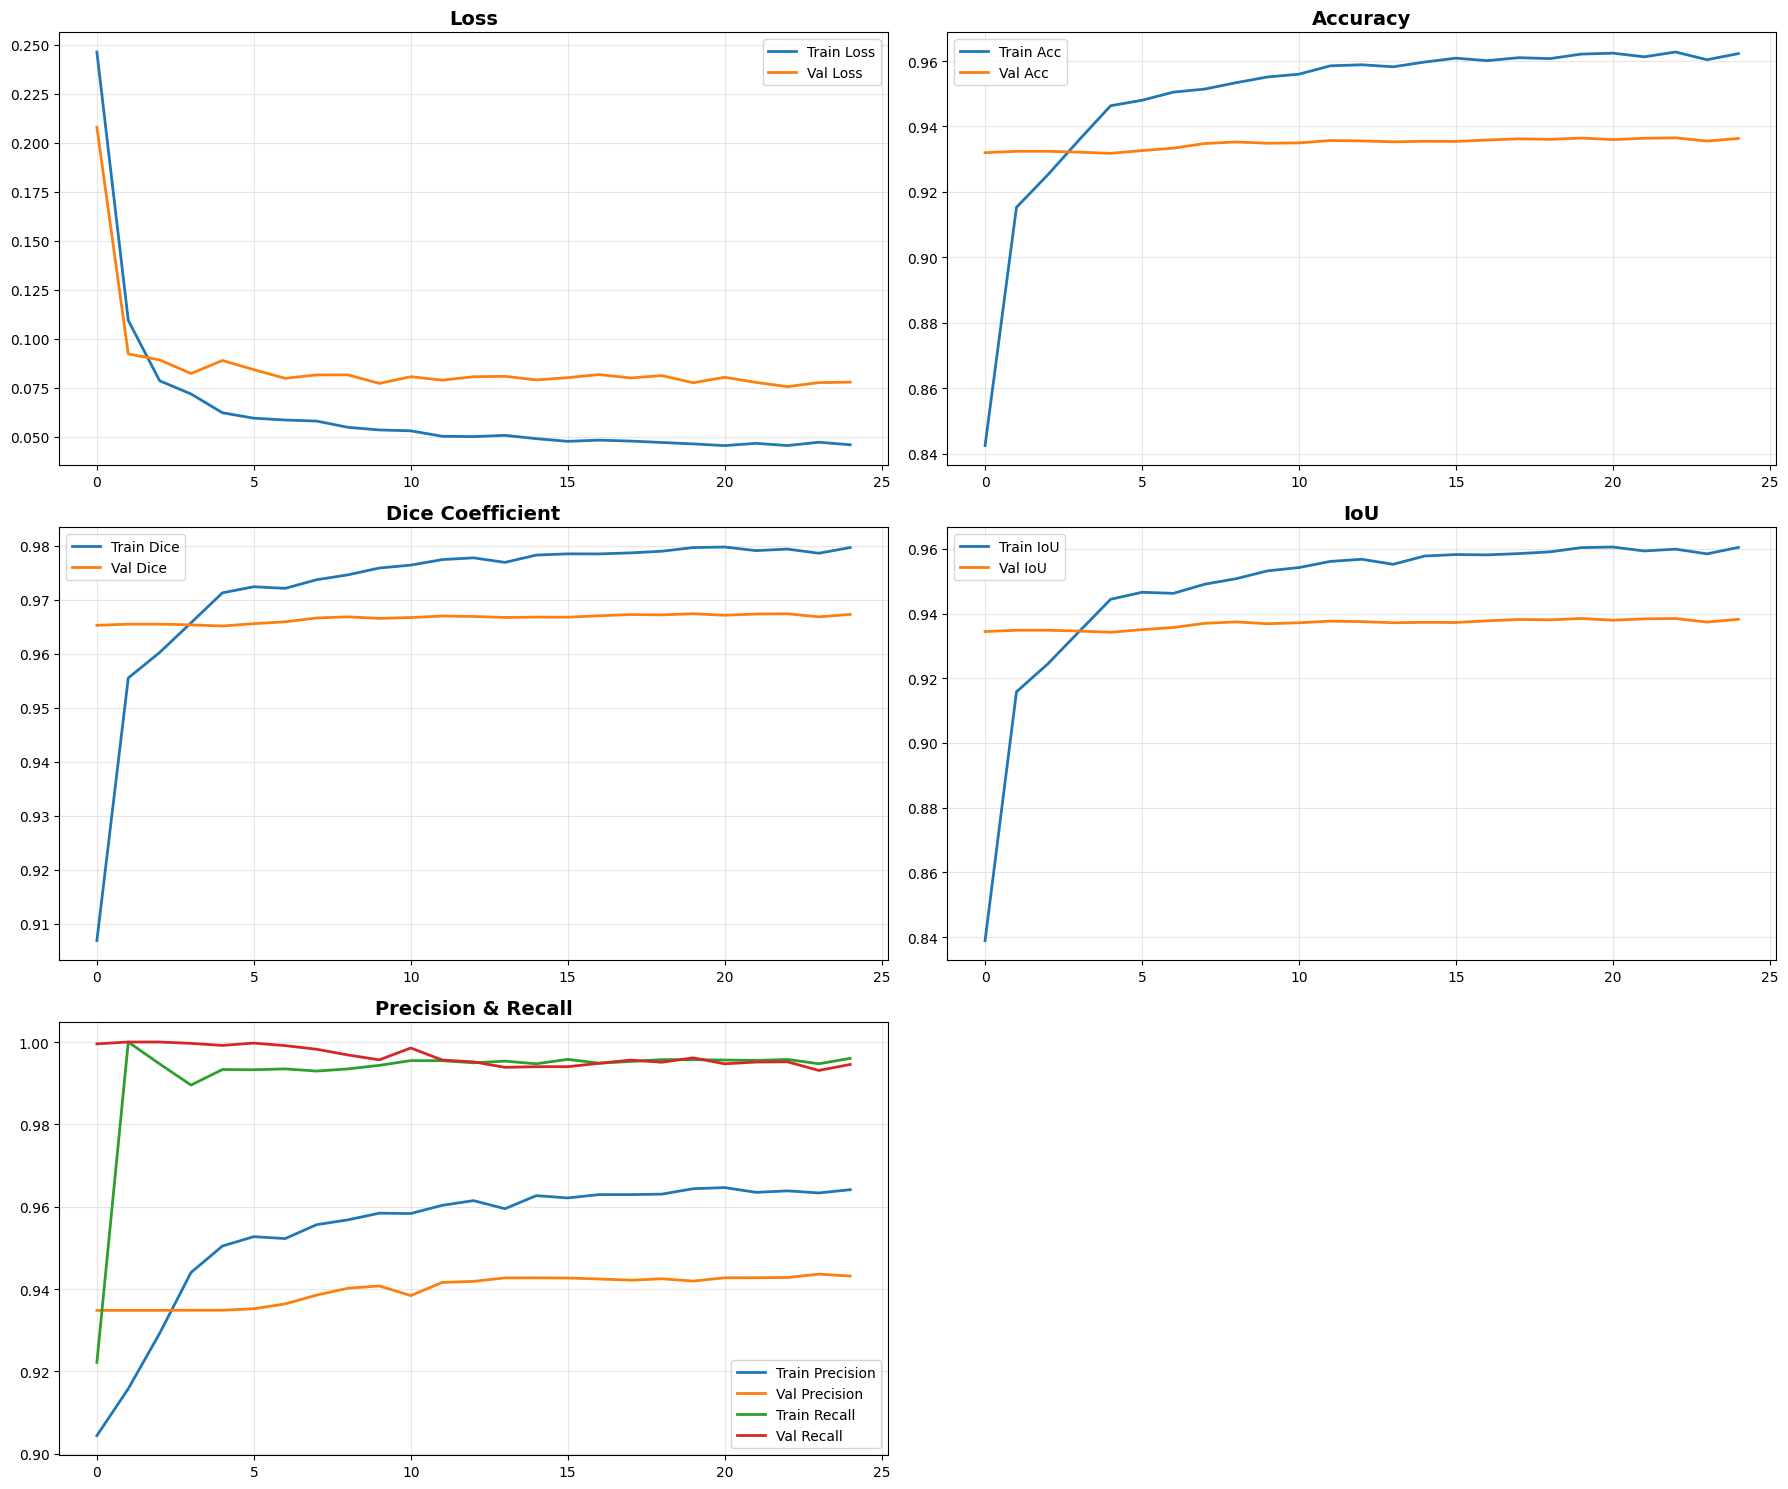

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Loss
axes[0,0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0,0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0,0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

# Accuracy
axes[0,1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0,1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0,1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

# Dice
axes[1,0].plot(history.history['dice_coef_improved'], label='Train Dice', linewidth=2)
axes[1,0].plot(history.history['val_dice_coef_improved'], label='Val Dice', linewidth=2)
axes[1,0].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

# IoU
axes[1,1].plot(history.history['iou_improved'], label='Train IoU', linewidth=2)
axes[1,1].plot(history.history['val_iou_improved'], label='Val IoU', linewidth=2)
axes[1,1].set_title('IoU', fontsize=14, fontweight='bold')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)

# Precision & Recall
axes[2,0].plot(history.history['precision_improved'], label='Train Precision', linewidth=2)
axes[2,0].plot(history.history['val_precision_improved'], label='Val Precision', linewidth=2)
axes[2,0].plot(history.history['recall_improved'], label='Train Recall', linewidth=2)
axes[2,0].plot(history.history['val_recall_improved'], label='Val Recall', linewidth=2)
axes[2,0].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[2,0].legend(); axes[2,0].grid(alpha=0.3)

axes[2,1].axis('off')
plt.tight_layout()
plt.show()

# 🔍 Sample Predictions Visualization

This snippet visualizes **segmentation results** on a few validation images:

### Steps:

1. **Select Images**
   - Iterates over the first 5 (or fewer) validation images.

2. **Preprocess & Predict**
   - Parses and resizes images & masks (`parse_image_mask_improved`)
   - Expands dimensions to create a batch (`tf.expand_dims`)
   - Generates predictions with the trained model
   - Converts predictions to **binary masks** using a 0.5 threshold

3. **Display**
   - **Original Image** (scaled back from preprocessing)
   - **Ground Truth Mask** (actual annotated mask)
   - **Prediction Heatmap** (model confidence)
   - **Prediction Binary** (thresholded mask)
   



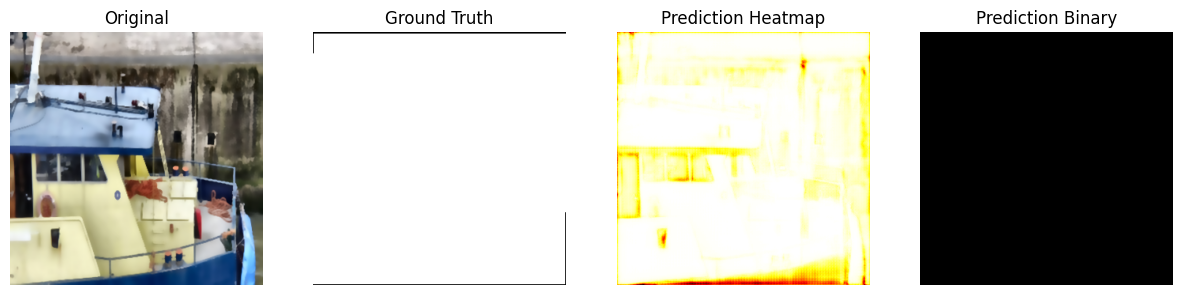

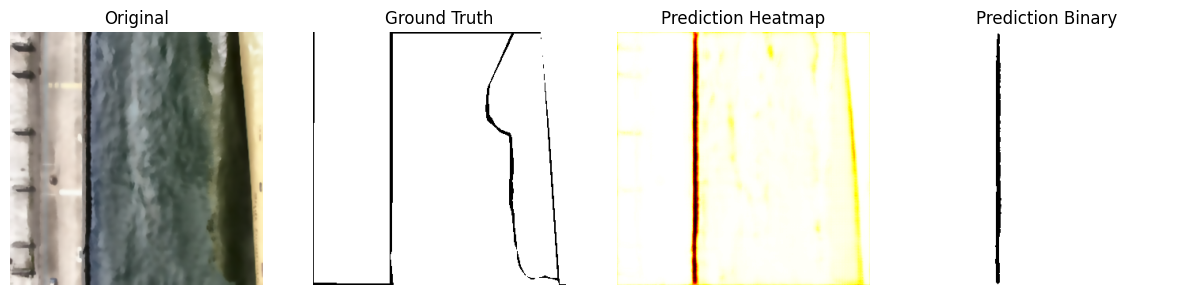

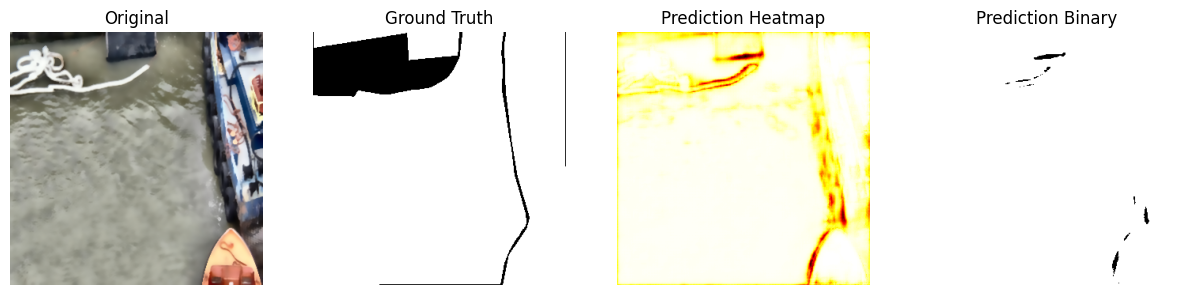

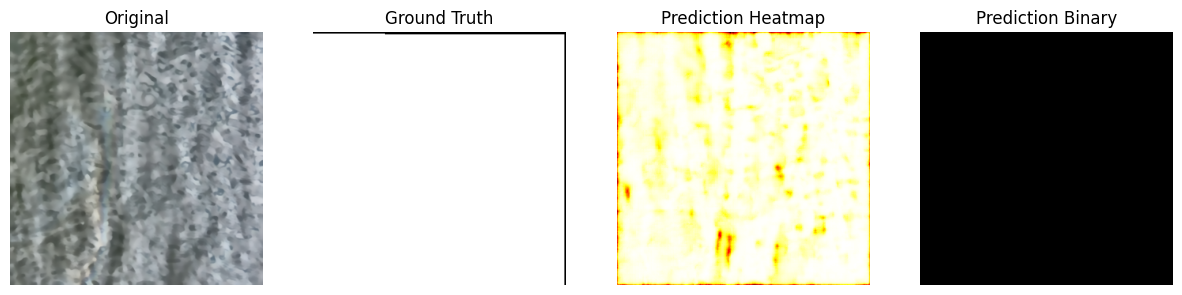

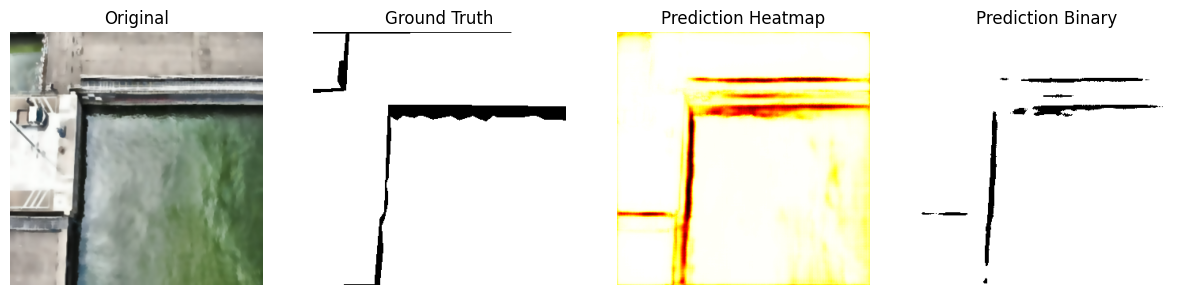

In [24]:
for i in range(min(5, len(val_imgs))):
    img, mask = parse_image_mask_improved(val_imgs[i], val_masks[i])
    img_batch = tf.expand_dims(img, 0)
    pred = model.predict(img_batch, verbose=0)[0]
    pred_binary = (pred > 0.5).astype(np.float32)

    img_display = (img.numpy() + 1.0) / 2.0

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img_display); plt.title('Original'); plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(mask.numpy().squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(pred.squeeze(), cmap='hot'); plt.title('Prediction Heatmap'); plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(pred_binary.squeeze(), cmap='gray'); plt.title('Prediction Binary'); plt.axis('off')
    plt.show()

## Overlay Visualization

The overlay visualization helps to compare the **original satellite images**, **ground truth masks**, and **predicted segmentation outputs** in a clear and intuitive way.

### Visual Components and Color Coding

1. **Original Image**
   - Shows the raw satellite image as input.
   - Serves as the reference for all overlays.

2. **Ground Truth (GT) Overlay**
   - The ground truth mask is overlaid on the original image.
   - **Red color** indicates the actual oil spill regions.
   - Helps to visualize where the spill truly exists.

3. **Prediction Overlay**
   - The model’s predicted mask is overlaid on the original image.
   - **Green color** indicates the regions predicted as oil spill by the model.
   - Useful to identify what the model thinks is positive.

4. **Combined Overlay**
   - Combines both ground truth and predicted masks on the original image.
   - **Blue color** → Correctly predicted oil spill (True Positive)  
   - **Red color** → Missed oil spill regions (False Negative)  
   - **Green color** → Incorrectly predicted spill where none exists (False Positive)  
  


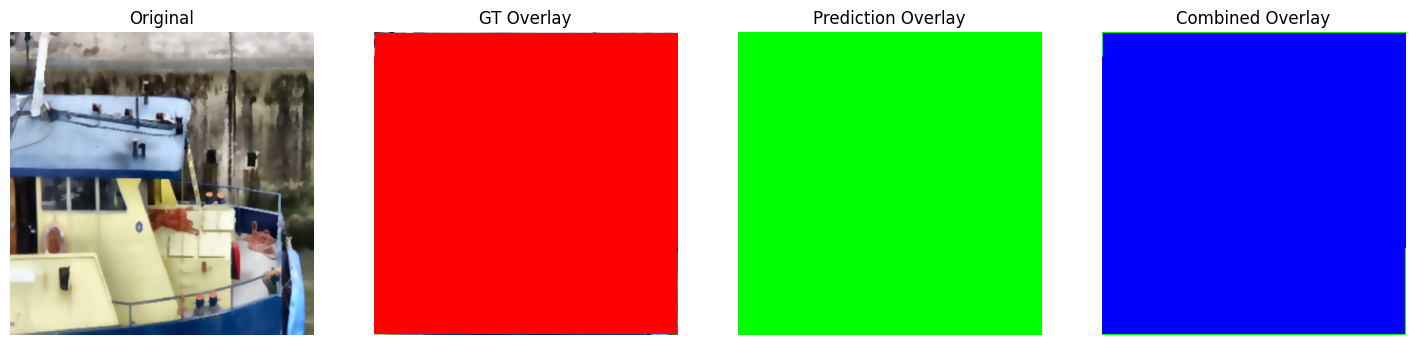

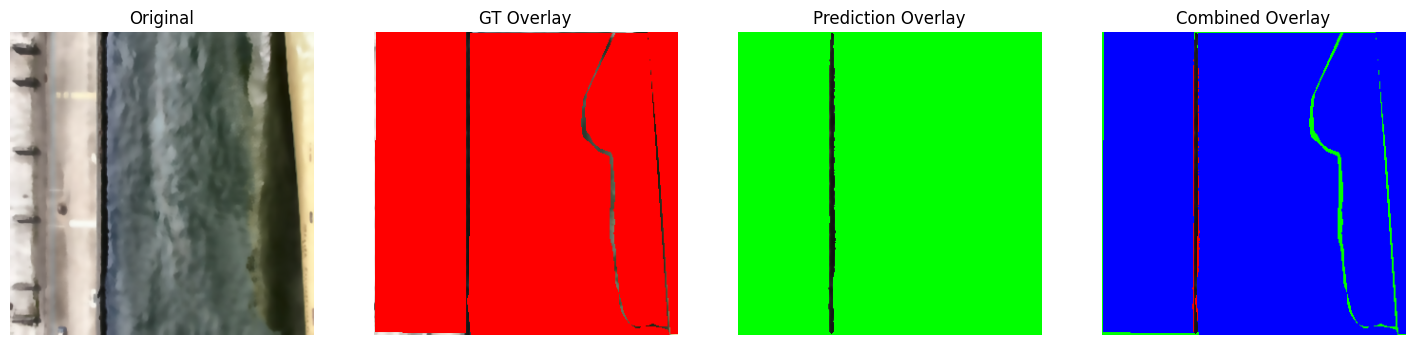

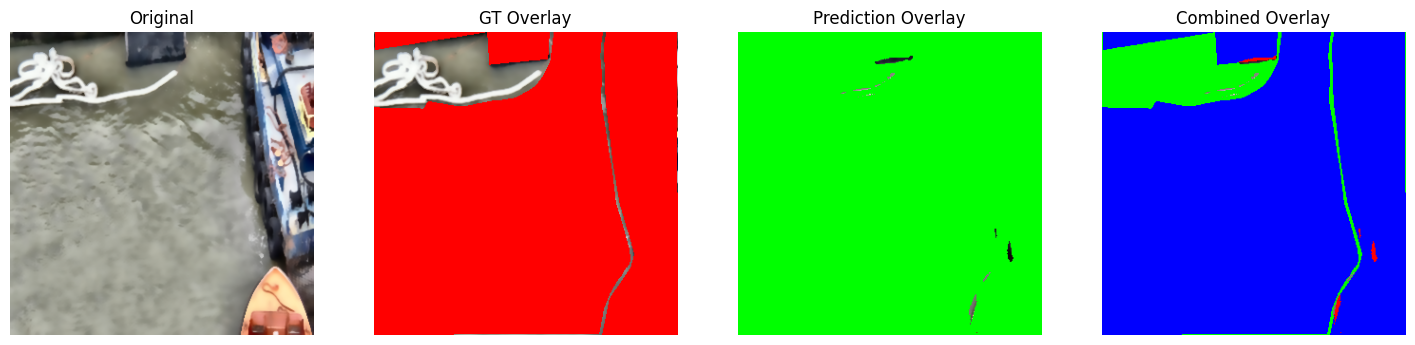

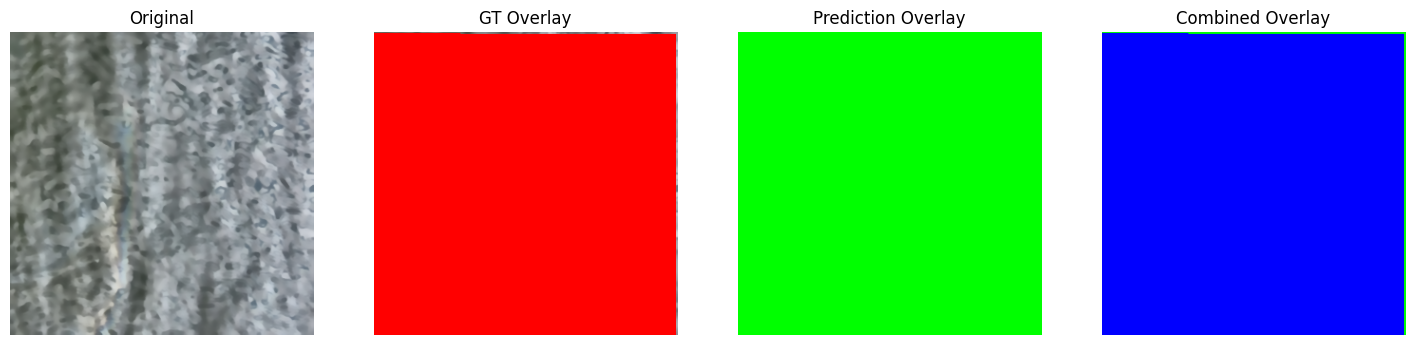

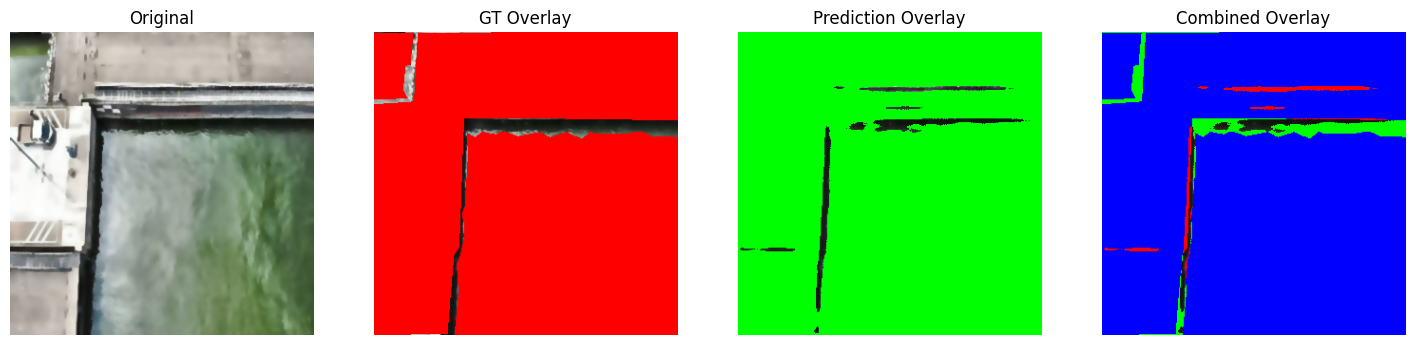

In [25]:
import cv2

for i in range(min(5, len(val_imgs))):
    img, mask = parse_image_mask_improved(val_imgs[i], val_masks[i])
    img_batch = tf.expand_dims(img, 0)
    pred = model.predict(img_batch, verbose=0)[0]
    pred_binary = (pred > 0.5).astype(np.uint8)

    img_display = (img.numpy() + 1.0) / 2.0

    # Overlay ground truth in red
    overlay_gt = img_display.copy()
    overlay_gt[mask.numpy().squeeze() > 0.5] = [1, 0, 0]  # red overlay

    # Overlay prediction in green
    overlay_pred = img_display.copy()
    overlay_pred[pred_binary.squeeze() > 0.5] = [0, 1, 0]  # green overlay

    # Combined overlay (both GT and Prediction)
    overlay_combined = img_display.copy()
    overlay_combined[(mask.numpy().squeeze() > 0.5) & (pred_binary.squeeze() > 0.5)] = [0, 0, 1]  # blue = overlap
    overlay_combined[(mask.numpy().squeeze() > 0.5) & (pred_binary.squeeze() == 0)] = [1, 0, 0]  # red = missed
    overlay_combined[(mask.numpy().squeeze() == 0) & (pred_binary.squeeze() > 0.5)] = [0, 1, 0]  # green = false positive

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1); plt.imshow(img_display); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 4, 2); plt.imshow(overlay_gt); plt.title("GT Overlay"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.imshow(overlay_pred); plt.title("Prediction Overlay"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.imshow(overlay_combined); plt.title("Combined Overlay"); plt.axis("off")
    plt.show()


## Confusion Matrix

A **confusion matrix** is a table used to evaluate the performance of a classification model by comparing the **predicted labels** against the **true labels**. It provides detailed insight into **how well the model is performing** for each class.

### Components in Our Context (Oil Spill Segmentation)

- **True Positive (TP):** Pixels correctly predicted as oil spill.  
- **True Negative (TN):** Pixels correctly predicted as non-spill.  
- **False Positive (FP):** Pixels incorrectly predicted as oil spill (predicted spill but actually no spill).  
- **False Negative (FN):** Pixels incorrectly predicted as non-spill (missed spill).  




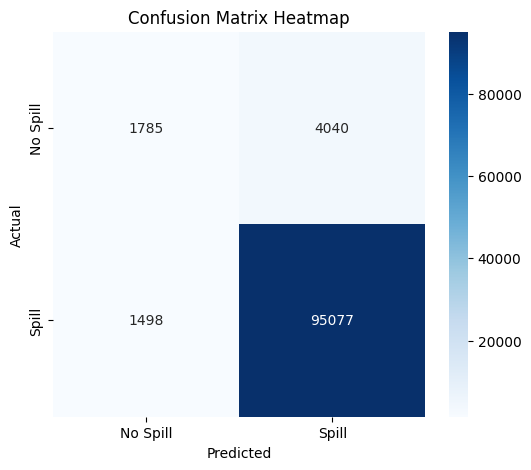

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example: flatten ground truth and predictions
y_true = mask.numpy().flatten()
y_pred = pred_binary.flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Spill", "Spill"], yticklabels=["No Spill", "Spill"])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Segmentation Metrics – Bar Chart Explanation

The **bar chart** visualizes the key performance metrics of the segmentation model in a clear and intuitive way. Each bar represents one metric, showing how well the model performed overall.



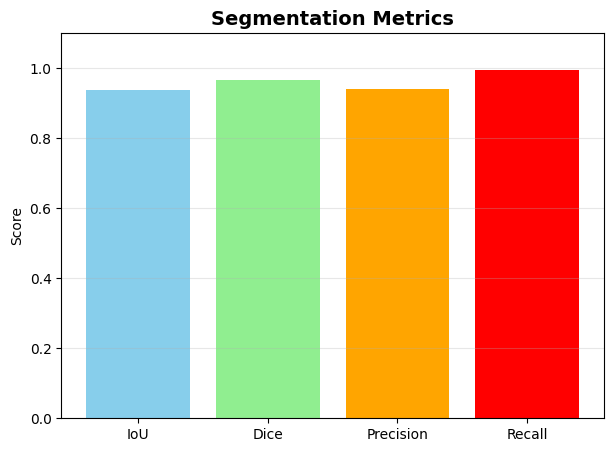

In [28]:
# Collect the final metric values
metrics = {
    "IoU": iou_metric_accum.result().numpy(),
    "Dice": dice_metric_accum.result().numpy(),
    "Precision": precision_metric.result().numpy(),
    "Recall": recall_metric.result().numpy()
}

# Plot bar chart
plt.figure(figsize=(7,5))
plt.bar(metrics.keys(), metrics.values(),
        color=["skyblue","lightgreen","orange","red"])
plt.title("Segmentation Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score")
plt.ylim(0,1.1)
plt.grid(axis="y", alpha=0.3)
plt.show()


## Pixel Distribution – Pie Chart Explanation

The **pie chart** visualizes the proportion of oil spill pixels versus background pixels in the ground truth mask. This gives an intuitive sense of how much of the image area is actually covered by oil spill regions.

### Details

- **Slices & Colors:**  
  - **Background Pixels** → Light Gray  
  - **Oil Spill Pixels** → Red  

- **Autopct:** Shows the percentage of each class in the image.  
- **Start Angle:** Rotated 90° for better orientation.  



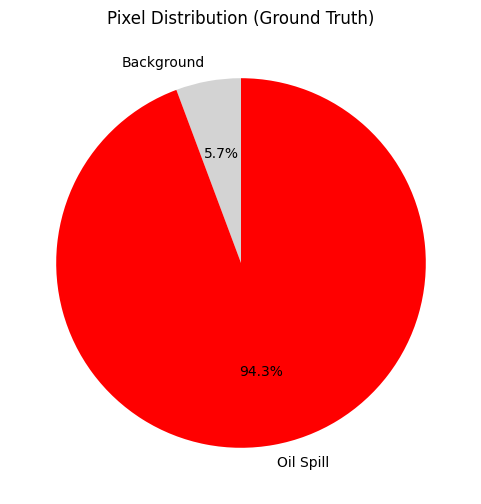

In [29]:
spill_pixels = (mask.numpy() > 0.5).sum()
background_pixels = (mask.numpy() <= 0.5).sum()

plt.figure(figsize=(6,6))
plt.pie([background_pixels, spill_pixels],
        labels=["Background","Oil Spill"],
        autopct='%1.1f%%',
        colors=["lightgray","red"],
        startangle=90)
plt.title("Pixel Distribution (Ground Truth)")
plt.show()


## Prediction Probability Distribution – Histogram

The **histogram** visualizes the distribution of predicted probabilities for each pixel in the segmentation output. This helps to understand the confidence of the model across the image.

### Details

- **X-axis:** Predicted probability values (from 0 to 1).  
- **Y-axis:** Number of pixels corresponding to each probability bin.  
- **Bins:** 50 bins to give a detailed view of probability spread.  
- **Color:** Purple, with 70% opacity for visual clarity.



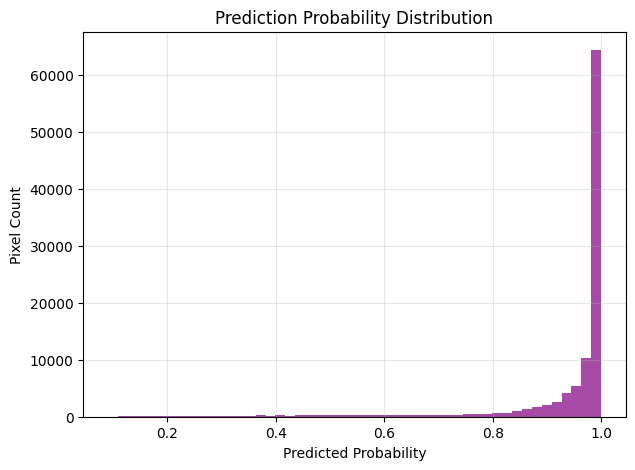

In [30]:
plt.figure(figsize=(7,5))
plt.hist(pred.flatten(), bins=50, color="purple", alpha=0.7)
plt.title("Prediction Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Pixel Count")
plt.grid(alpha=0.3)
plt.show()


## IoU vs Dice Scatter Plot

This **scatter plot** visualizes the relationship between **Intersection over Union (IoU)** and **Dice Coefficient** for each validation image. It helps to assess how consistently the model performs across different samples.

### Details

- **X-axis:** IoU scores per image.  
- **Y-axis:** Dice Coefficient scores per image.  
- **Color:** Teal, with 70% opacity for better visibility of overlapping points.  
- **Each point:** Represents one validation image.

### Interpretation

- Points **close to the top-right corner (1,1)** indicate images where the model performed very well (high overlap with ground truth).  
- Points **away from the top-right** indicate images where the model struggled or predictions were less accurate.  
- Clustering of points gives an idea of **overall consistency** of model predictions.



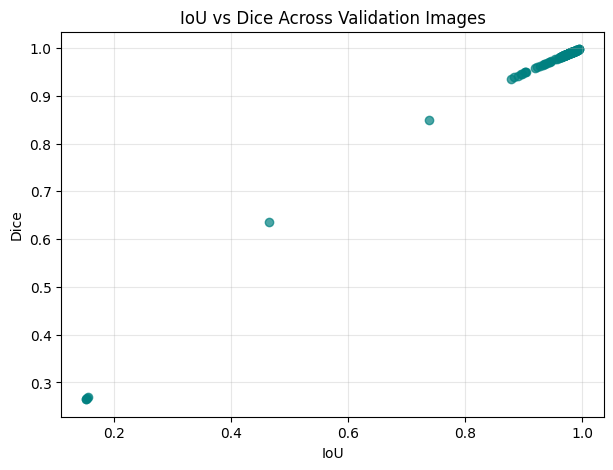

In [31]:
# Lists to store per-image metrics
iou_list = []
dice_list = []

for imgs, masks in val_dataset:
    preds = model(imgs, training=False)
    batch_size = imgs.shape[0]

    for i in range(batch_size):
        y_true = masks[i:i+1]
        y_pred = preds[i:i+1]

        iou_val = iou_improved(y_true, y_pred).numpy()
        dice_val = dice_coef_improved(y_true, y_pred).numpy()

        iou_list.append(iou_val)
        dice_list.append(dice_val)

# Convert to numpy arrays
iou_scores = np.array(iou_list)
dice_scores = np.array(dice_list)

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(iou_scores, dice_scores, color="teal", alpha=0.7)
plt.title("IoU vs Dice Across Validation Images")
plt.xlabel("IoU")
plt.ylabel("Dice")
plt.grid(alpha=0.3)
plt.show()
